In [33]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import pdb
import h5py
from transformers import GPT2Tokenizer
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

class AttrDict(dict):
    __setattr__ = dict.__setitem__

    def __getattr__(self, attr):
        try:
            return self.__getitem__(attr)
        except KeyError:
            raise AttributeError("Attribute %r not found" % attr)

    def __getstate__(self):
        return self

    def __setstate__(self, d):
        self = d

def collate_batch(batch):

    behaviour_lengths = [item.behaviour_length for item in batch]

    images = [torch.tensor(item.observations) for item in batch]
    images = pad_sequence(images, batch_first=True, padding_value=0.0)

    actions = [torch.tensor(item.actions) for item in batch]
    actions = pad_sequence(actions, batch_first=True, padding_value=0.0)

    instructions = torch.stack([torch.tensor(item.instruction) for item in batch])

    gpt_tokens = torch.stack([item.gpt_tokens for item in batch])
    gpt_mask = torch.stack([item.gpt_mask for item in batch])

    gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Decode gpt tokens into text
    text_list = []
    stop_words = ['close', 'move', 'next', 'push', 'put', 'slide', 'the', 'to', 'towards', '!', '\n']

    # Decode gpt tokens into text
    text_list = [gpt_tokenizer.decode(x).replace("!", "").split() for x in gpt_tokens]

    # Remove stop words
    stop_words = set(['close', 'move', 'next', 'push', 'put', 'slide', 'the', 'to', 'towards', '!', '\n'])
    text_list_clean = [[word for word in sublist if word not in stop_words] for sublist in text_list]

    # print(text_list_clean)
    # text_list_clean_array = np.array(text_list_clean)
    text_list_clean_array = np.array(text_list_clean, dtype=object)

    # print(text_list_clean_array)

    #similarity_matrix = (text_list_clean_array[:, None] == text_list_clean_array).all(axis=2)
    similarity_matrix = (text_list_clean_array[:, None] == text_list_clean_array).all()

    # print(similarity_matrix)
    
    # false_negative_mask = similarity_matrix

    # ??????????
    false_negative_mask = similarity_matrix  - np.eye(len(text_list_clean), dtype=float)
    false_negative_mask = np.logical_not(false_negative_mask).astype(float)
    false_negative_mask = np.where(false_negative_mask == 0.0, -np.inf, false_negative_mask)
    false_negative_mask = np.where(false_negative_mask == 0.0, -1e20, false_negative_mask)

    return AttrDict({'observations': images, 'actions': actions, 'instruction': instructions, 
                     'gpt_tokens': gpt_tokens, 'gpt_mask': gpt_mask, 'false_negative_mask': false_negative_mask,
                     'behaviour_lengths': behaviour_lengths})


class BehaviourDatasetCached(Dataset):
    def __init__(self, phase='train', data=None):

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        self.all_data = data

        dataset_len = len(list(self.all_data.keys()))
        # dataset_len = 50000
        self.dataset_indices = np.arange(dataset_len)
        np.random.seed(0)
        np.random.shuffle(self.dataset_indices)

        if phase == 'train':
            self.dataset = self.dataset_indices[:int(0.8 * dataset_len)]
            print("Dataset length: ", len(self.dataset))

        elif phase == 'val':
            self.dataset = self.dataset_indices[int(0.8 * dataset_len):]
            print("Dataset length: ", len(self.dataset))

        self.max_seq_len = 25
        self.prefix_length = 10

        self.transform = transforms.Compose([
            transforms.Resize((180, 180)),
            transforms.ToTensor() 
        ])

    def pad_tokens(self, text_data):
        tokens = torch.tensor(self.gpt_tokenizer.encode(text_data), dtype=torch.int64)
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        index = self.dataset[idx]
        data = self.all_data[str(index)]
        observations = data["observations"][()]
        actions = data["actions"][()]
        instruction = data["clip_instruction_features"][()].squeeze(0)
        text_data = data["instruction"][()]
        behaviour_length = actions.shape[0]

        gpt_tokens, gpt_mask = self.pad_tokens(text_data.decode())
        
        return AttrDict({'observations': observations, 'actions': actions, 'instruction': instruction, 
                         'gpt_tokens': gpt_tokens, 'gpt_mask': gpt_mask, 'behaviour_length': behaviour_length})
    


dataset = h5py.File('/media/tim/E/datasets/lang_table/lang_table_test.h5', 'r')
train_dataset = BehaviourDatasetCached(phase='train', data=dataset)

train_dataloader = DataLoader(train_dataset, 
                                batch_size=64, 
                                shuffle=True, 
                                drop_last=True,
                                num_workers=6,
                                prefetch_factor=5,
                                collate_fn=collate_batch)


for batch in train_dataloader:
    print("observations: ", batch.observations.shape)
    print("instructions: ", batch.instruction.shape)
    print("actions: ", batch.actions.shape)
    print("gpt_tokens: ", batch.gpt_tokens.shape)
    print("gpt_mask: ", batch.gpt_mask.shape)
    print(batch.gpt_tokens[1])
    print(batch.gpt_mask[1])
    # print("behaviour_length: ", batch.behaviour_length)
    print("#############################################")
    break

Dataset length:  353780


2023-08-25 12:41:03.727006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 12:41:03.748385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 12:41:03.764118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25

observations:  torch.Size([64, 42, 2048])
instructions:  torch.Size([64, 512])
actions:  torch.Size([64, 42, 2])
gpt_tokens:  torch.Size([64, 25])
gpt_mask:  torch.Size([64, 35])
tensor([6649,  485,  262, 2266, 9197, 3371,  262, 4220, 3641,  220,  198,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
#############################################


In [54]:
import config as CFG
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(CFG.datapath_training_abcd)
annotations = np.load(f"{caption_path_training}", allow_pickle=True).item()
annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"], annotations["language"]["task"]))
print(annotations)

[((1572904, 1572946), 'pick up the red block lying in the drawer', 'lift_red_block_drawer'), ((1441275, 1441316), 'push the switch downwards', 'turn_off_lightbulb'), ((510341, 510405), 'slide the door to the left', 'move_slider_left'), ((170122, 170186), 'open the drawer', 'open_drawer'), ((170786, 170850), 'turn on the yellow lamp', 'turn_on_lightbulb'), ((413465, 413505), 'place the grasped object in the drawer', 'place_in_drawer'), ((924205, 924269), 'go towards the pink block in the drawer and pick it up', 'lift_pink_block_drawer'), ((944471, 944535), 'grasp the red block and turn it right', 'rotate_red_block_right'), ((764972, 765036), 'grasp the pink block and turn it right', 'rotate_pink_block_right'), ((426910, 426974), 'move down the switch', 'turn_off_lightbulb'), ((631864, 631928), 'turn off the green light', 'turn_off_led'), ((558179, 558243), 'put the grasped object in the drawer', 'place_in_drawer'), ((1001911, 1001954), 'toggle the button to turn on the led', 'turn_on_le

{'calvin_scene_B': [0, 598909], 'calvin_scene_C': [598910, 1191338], 'calvin_scene_A': [1191339, 1795044]}
[0, 598909]
[(868330, 868366), (1091564, 1091628), (633372, 633436), (789517, 789581), (712441, 712505), (633368, 633432), (632268, 632332), (778255, 778319), (688906, 688970), (1162988, 1163052), (632266, 632330), (1162983, 1163047), (735787, 735851), (689010, 689074), (638265, 638329), (623175, 623239), (789527, 789591), (689005, 689069), (712447, 712511), (616315, 616356), (688999, 689063), (658198, 658262), (637491, 637555), (735797, 735861), (688997, 689061), (735792, 735856), (1112391, 1112455), (712449, 712513), (684240, 684304), (862762, 862826), (632271, 632335), (621046, 621110), (1035368, 1035432), (756525, 756589), (637486, 637550), (628217, 628265), (1112382, 1112446), (756528, 756592), (738702, 738766), (616323, 616363), (623185, 623249), (995948, 995990), (621054, 621118), (689004, 689068), (868325, 868365), (778248, 778312), (801587, 801651), (1113258, 1113301), (6

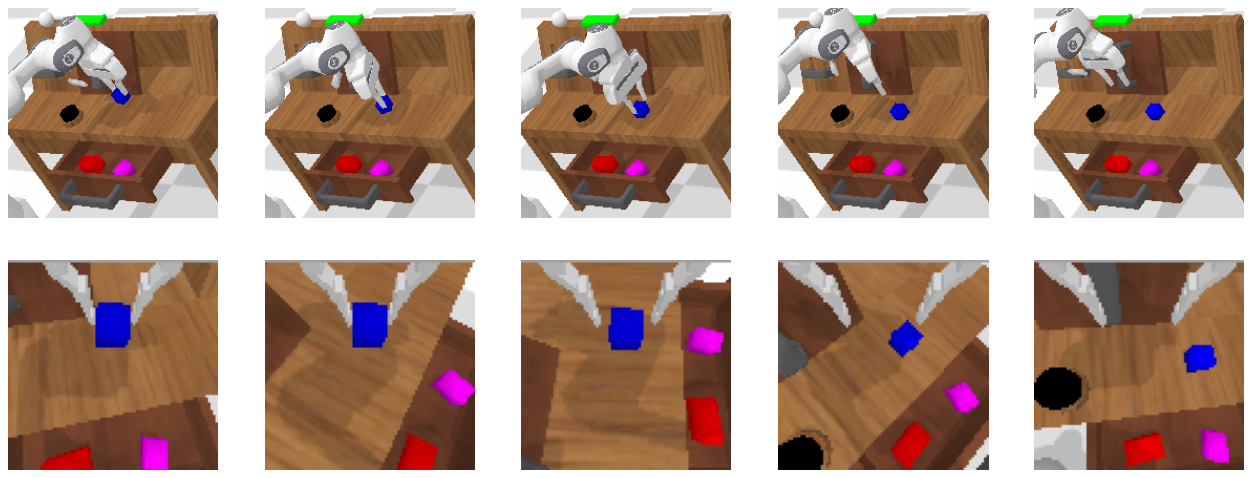

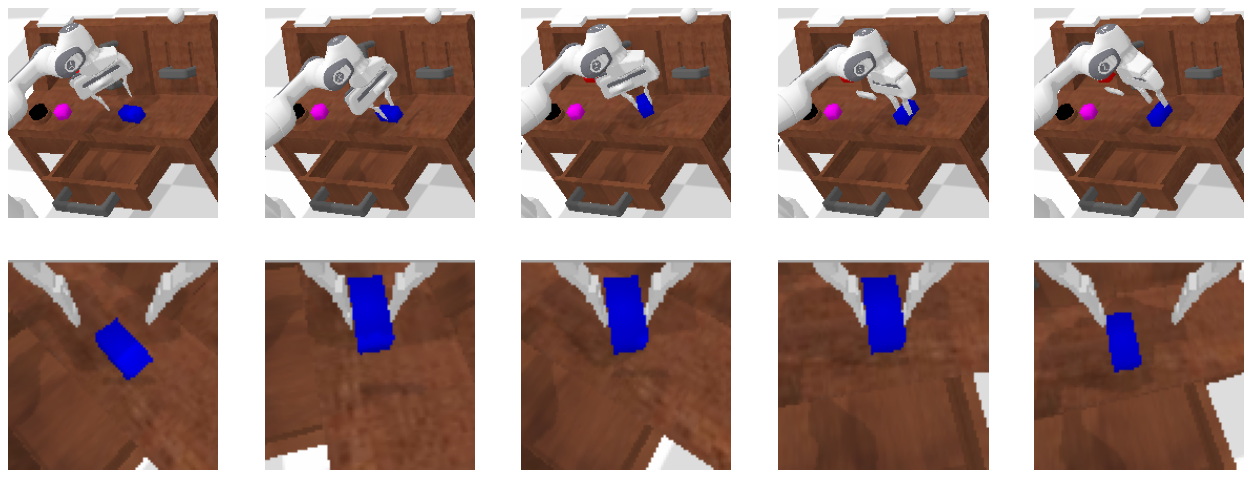

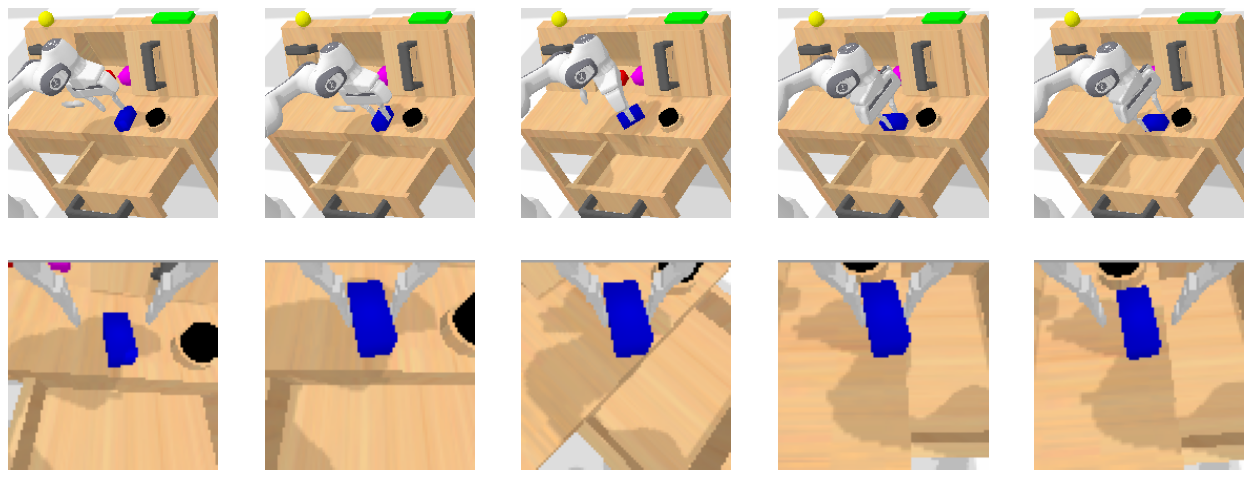

In [58]:
from utils.visualize import showImages
import config as CFG
import numpy as np

datapath_training_parsed = CFG.datapath_training_abcd
datapath_val_parsed = CFG.datapath_val_abcd
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_val_parsed)

annotations = np.load(f"{caption_path_training}", allow_pickle=True).item()
tasks = list(zip(annotations["info"]["indx"], annotations["language"]["task"]))
#print(tasks[1])

info = np.load(f"{CFG.datapath_training_abcd}/scene_info.npy", allow_pickle=True).item()
#print(info)
print(info)
print(info['calvin_scene_B'])

tasks_per_scene = {}

for task in tasks:
    scene = ''
    if task[0][1] <= info['calvin_scene_B'][1]:
        scene = 'calvin_scene_B'
    elif task[0][1] <= info['calvin_scene_C'][1]:
        scene = 'calvin_scene_C'
    elif task[0][1] <= info['calvin_scene_A'][1]:
        scene = 'calvin_scene_A'

    if scene == '':
        continue

    if task[1] not in tasks_per_scene:
        tasks_per_scene[task[1]] = {}

    if scene not in tasks_per_scene[task[1]]:
        tasks_per_scene[task[1]][scene] = []

    tasks_per_scene[task[1]][scene].append(task[0])


print(tasks_per_scene['rotate_blue_block_right']['calvin_scene_C'])

showImages(tasks_per_scene['rotate_blue_block_right']['calvin_scene_C'][0][0], CFG.datapath_training_abcd)
showImages(tasks_per_scene['rotate_blue_block_right']['calvin_scene_A'][0][0], CFG.datapath_training_abcd)
showImages(tasks_per_scene['rotate_blue_block_right']['calvin_scene_B'][0][0], CFG.datapath_training_abcd)